In [ ]:
# https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
data = pd.read_csv('sample_data/AirPassengers.csv', parse_dates=True, index_col='Month')

data.dtypes

#Passengers    int64
dtype: object

In [11]:
# data.index

In [5]:
ts = data['#Passengers']
ts.head(5)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

### STATIONARITY
This is a very important concept in Time Series Analysis. In order to apply a time series model, it is important for the Time series to be stationary; in other words all its statistical properties (mean,variance) remain constant over time. 

This is done basically because if you take a certain behavior over time, it is important that this behavior is same in the future in order for us to forecast the series. There are a lot of statistical theories to explore stationary series than non-stationary series. (Thus we can bring the fight to our home ground!)

In practice we can assume the series to be stationary if it has constant statistical properties over time and these properties can be:
- constant mean
- constant variance

#### Checks for Stationarity
There are many methods to check whether a time series (direct observations, residuals, otherwise) is stationary or non-stationary.

**Look at Plots:** You can review a time series plot of your data and visually check if there are any obvious trends or seasonality.

**Summary Statistics:** You can review the summary statistics for your data for seasons or random partitions and check for obvious or significant differences.

**Statistical Tests:** You can use statistical tests to check if the expectations of stationarity are met or have been violated. 

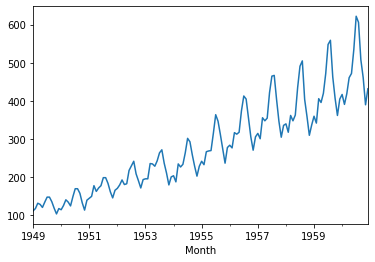

In [6]:
ts.plot()

#### Dickey-Fuller Test for Stationarity
The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

p-value > 0.05: Accept the null hypothesis (H0), the data is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data is stationary.

If the test statistic is less than the critical value, we can reject the null hypothesis (aka the series is stationary). When the test statistic is greater than the critical value, we fail to reject the null hypothesis (which means the series is not stationary).


In [7]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    d = {}
    d['ADF result'] = dftest[0]
    d['p-value'] = dftest[1]
    d['lags used'] = dftest[2]
    d['no. of observations used'] = dftest[3]
    for key in dftest[4]:
        d[key] = dftest[4][key]
    print(d)
    

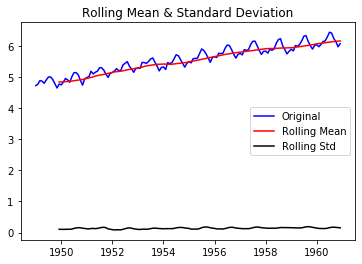

Results of Dickey-Fuller Test:
{'ADF result': -1.7170170891069665, 'p-value': 0.4223667747703883, 'lags used': 13, 'no. of observations used': 130, '1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}


In [11]:

#test_stationarity(ts)
test_stationarity(ts_log)

This is not stationary because :
- mean is increasing even though the std is small.
- Test stat is > critical value.
- Note: the signed values are compared and the absolute values.

#### MAKING THE TIME SERIES STATIONARY

There are two major factors that make a time series non-stationary. They are:

- Trend: non-constant mean
- Seasonality: Variation at specific time-frames

##### Trend
The first step is to reduce the trend using transformation, as we can see here that there is a strong positive trend. These transformation can be log, sq-rt, cube root etc . Basically it penalizes larger values more than the smaller. In this case we will use the logarithmic transformation.

There are some methods to model these trends and then remove them from the series. Some of the common ones are:
- Smoothing: using rolling/moving average
- Aggression: by taking the mean for a certain time period (year/month)


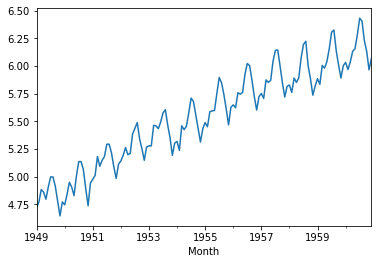

In [9]:
ts_log = np.log(ts)
ts_log.plot()

In [12]:
moving_avg = pd.Series(ts_log).rolling(window=12).mean()

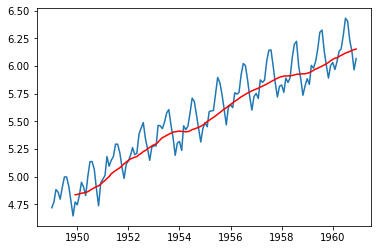

In [13]:
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [15]:
ts_log_moving_avg_diff = ts_log - moving_avg

In [16]:
ts_log_moving_avg_diff

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
                ...   
1960-08-01    0.282363
1960-09-01    0.098235
1960-10-01   -0.009230
1960-11-01   -0.182690
1960-12-01   -0.085789
Name: #Passengers, Length: 144, dtype: float64

In [17]:
ts_log_moving_avg_diff.dropna(inplace=True)

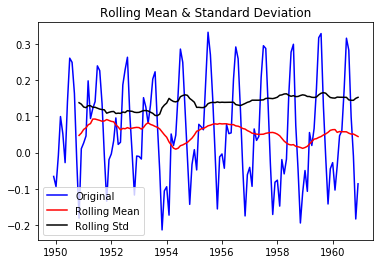

Results of Dickey-Fuller Test:
{'ADF result': -3.1629079913008633, 'p-value': 0.02223463000124353, 'lags used': 13, 'no. of observations used': 119, '1%': -3.4865346059036564, '5%': -2.8861509858476264, '10%': -2.579896092790057}


In [18]:
test_stationarity(ts_log_moving_avg_diff)

Seasonality (along with Trend)
Previously we saw just trend part of the time series, now we will see both trend and seasonality. Most Time series have trends along with seasonality. There are two common methods to remove trend and seasonality, they are:
- Differencing: by taking difference using time lag
- Decomposition: model both trend and seasonality, then remove them

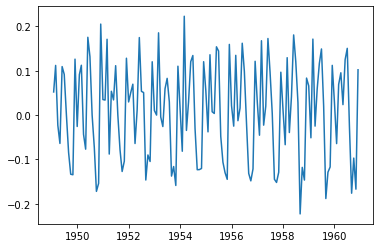

In [20]:
# differencing 
ts_log_diff = ts_log - ts_log.shift()

plt.plot(ts_log_diff)

In [21]:
ts_log_diff.dropna(inplace=True)

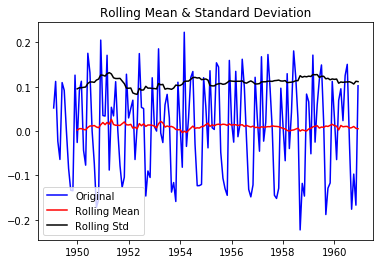

Results of Dickey-Fuller Test:
{'ADF result': -2.7171305983881564, 'p-value': 0.07112054815085475, 'lags used': 14, 'no. of observations used': 128, '1%': -3.4825006939887997, '5%': -2.884397984161377, '10%': -2.578960197753906}


In [22]:
test_stationarity(ts_log_diff)

In [23]:
# decomposing
from statsmodels.tsa.seasonal import seasonal_decompose

In [24]:
decomposition = seasonal_decompose(ts_log)

In [25]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

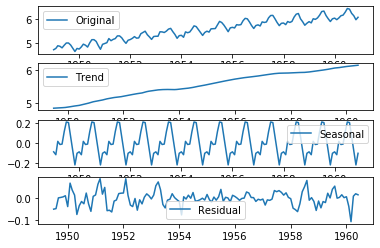

In [26]:
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend()

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(seasonal,label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend()

In [27]:
ts_log_decompose = residual

In [28]:
ts_log_decompose.dropna(inplace=True)

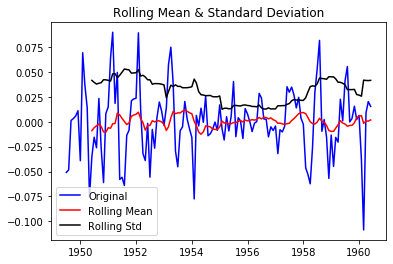

Results of Dickey-Fuller Test:
{'ADF result': -6.332386797644897, 'p-value': 2.885058903322897e-08, 'lags used': 9, 'no. of observations used': 122, '1%': -3.4851223522012855, '5%': -2.88553750045158, '10%': -2.5795685622144586}


In [29]:
test_stationarity(ts_log_decompose)

### Forecasting a Time Series


We will use statistical modelling method called ARIMA to forecast the data where there are dependencies in the values.

Auto Regressive Integrated Moving Average(ARIMA) — It is like a liner regression equation where the predictors depend on parameters (p,d,q) of the ARIMA model .

Auto Regressive - p
Difference - d
moving Avg - q



### AutoCorrelation Plot and Partial Correleation Plot

In [31]:
from statsmodels.tsa.arima_model import ARIMA

In [32]:
from statsmodels.tsa.stattools import acf, pacf

In [33]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

c:\users\maury\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Partial Autocorrelation Function Plot')

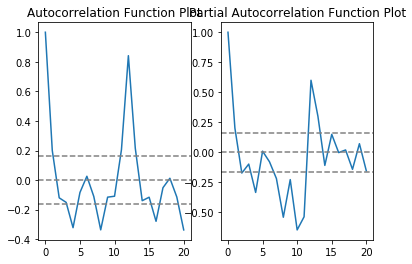

In [34]:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=1.96/(np.sqrt(len(ts_log_diff))), linestyle='--', color='gray')
plt.axhline(y=-1.96/(np.sqrt(len(ts_log_diff))), linestyle='--', color='gray')
plt.title('Autocorrelation Function Plot')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=1.96/(np.sqrt(len(ts_log_diff))), linestyle='--', color='gray')
plt.axhline(y=-1.96/(np.sqrt(len(ts_log_diff))), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function Plot')

- p: The first time where the ACF crosses the upper confidence interval, here its close to 2. hence p = 2.
- q: The first time where the PACF crosses the upper confidence interval, here its close to 2. hence q = 2

c:\users\maury\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\users\maury\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.0292')

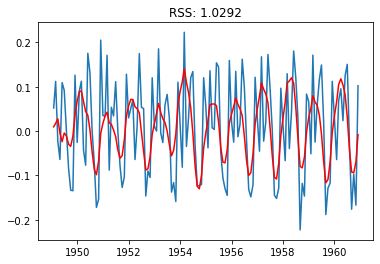

In [40]:
model = ARIMA(ts_log, order=(2,1,2))
results_ARIMA = model.fit()
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [42]:
## back to original

prediction_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
prediction_ARIMA_diff

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
                ...   
1960-08-01   -0.041176
1960-09-01   -0.092350
1960-10-01   -0.094013
1960-11-01   -0.069924
1960-12-01   -0.008127
Length: 143, dtype: float64

In [43]:
prediction_ARIMA_cumsum = prediction_ARIMA_diff.cumsum()
prediction_ARIMA_cumsum

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
                ...   
1960-08-01    1.372553
1960-09-01    1.280203
1960-10-01    1.186190
1960-11-01    1.116266
1960-12-01    1.108139
Length: 143, dtype: float64

In [44]:
prediction_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
prediction_ARIMA_log = prediction_ARIMA_log.add(prediction_ARIMA_cumsum, fill_value=0)

prediction_ARIMA_log

c:\users\maury\miniconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
                ...   
1960-08-01    6.091051
1960-09-01    5.998702
1960-10-01    5.904689
1960-11-01    5.834765
1960-12-01    5.826638
Length: 144, dtype: float64

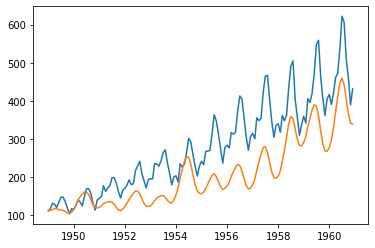

In [45]:
prediction_ARIMA = np.exp(prediction_ARIMA_log)
plt.plot(ts)
plt.plot(prediction_ARIMA)